In [1]:
#!unzip fashion-mnist.zip

In [2]:
from glob import glob 
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from PIL import Image
import torch
from torch.autograd import Variable

In [4]:
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)


In [5]:
train_files[0]

'./fashion-mnist/train/9/57800.png'

In [6]:
len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [7]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))



N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )


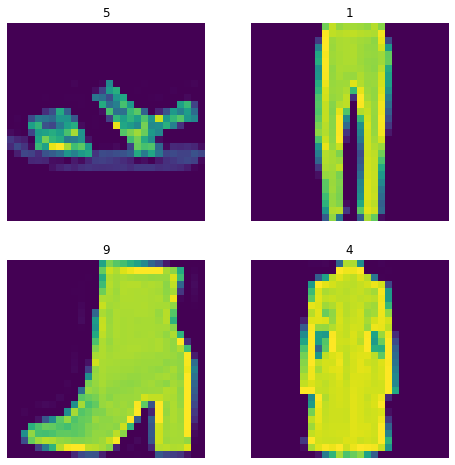

In [8]:
ig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [10]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [11]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Debe ser diferente a la utilizada en clase.

Tener al menos dos capas convolucionales.

Tener capas de Max o Global Average Pooling.

In [12]:

#--- Definimos la CNN

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
  # ( (28-5+2*2)/1 ) + 1 = 28   -> 28*28*8

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 28/2 =14                 -> 14*14*8

  torch.nn.Dropout(p=0.2),

  torch.nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
  # ( (7-5+2*2)/1 ) + 1 = 14   -> 14*14*16

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 14/2 = 7                 -> 7*7*16

  torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(7*7*32, 10)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=10, bias=True)
)

In [13]:
#!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


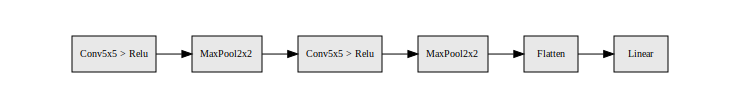

In [14]:
import hiddenlayer as hl

hl.build_graph(model, torch.zeros([32,1,28,28]))

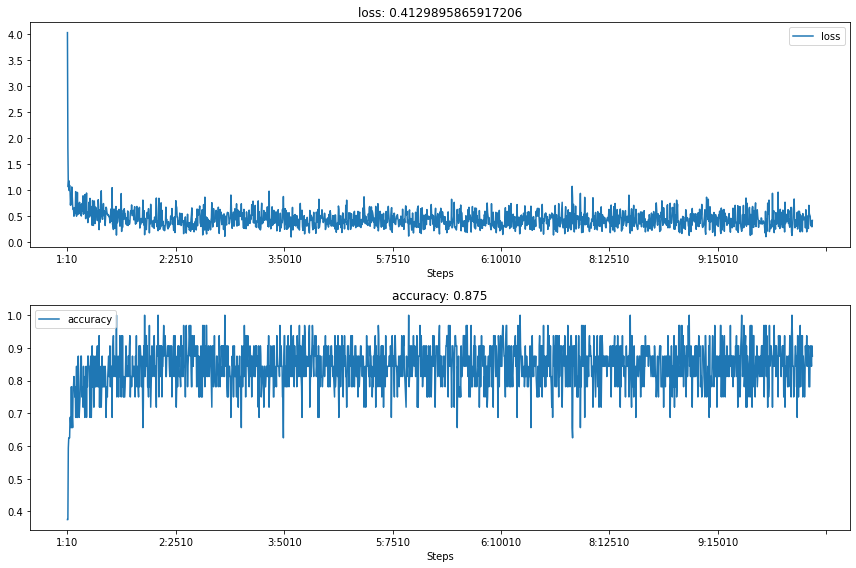

In [15]:
from sklearn.metrics import f1_score

n_epoch = 10
 
history = hl.History()
canvas = hl.Canvas()
iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()
    #print(X_train_batch.size())
    Xtr = X_train_batch.unsqueeze(1)
    #print(Xtr.size())
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])

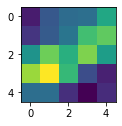

In [26]:
kernels = list(model.children())[0].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels[0].size(0)):
    plt.subplot(2,8,k+1)
    plt.imshow(kernels[i].squeeze())
    k += 1
plt.show()

In [28]:
print(kernels.size(0))

16
